In [1]:
import numpy as np    
import scipy.stats   
import pylab as plt  

Read the npy file

In [2]:
input_file_path = '/Users/giulia/coding/astrostat/astrostatistics_bicocca_2024/solutions/transient.npy'
data = np.load(input_file_path)

#print(data)

This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

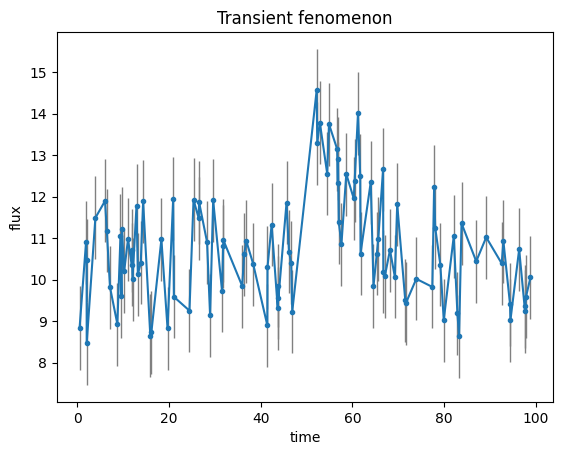

In [3]:
t,y,yerr=data.T

plt.errorbar(t,y,yerr=yerr, marker = '.', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')

plt.show()

### Dynesty

Using the crash course: https://dynesty.readthedocs.io/en/latest/crashcourse.html

# Burst

The model

In [4]:
def burst_model(x, theta):
    A, b, t0, alpha = theta
    result = b + A * np.exp(-alpha * (x - t0))
    result[x < t0] = b
    return result

The log likelihood

In [5]:
def LogLikelihood(theta, data, model):
    x, y, sigma_y = data.T
    if model=='burst':
        y_model = burst_model(x, theta)
    if model=='gauss':
        y_model = gauss_model(x, theta)
    return -0.5 * np.sum((y-y_model)**2 / sigma_y**2 ) 

The log prior

In [6]:
Amin, Amax = 0, 50
bmin, bmax = 0, 50
t0min, t0max = 0, 100
alphamin, alphamax = np.exp(-5), np.exp(5)

def burst_prior_transform(u):
    x = np.zeros(len(u))

    x[0] = scipy.stats.uniform(loc=Amin, scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin, scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min, scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3], alphamin, alphamax)

    # Tried but too slow
    #u = np.random.rand(4)  
    #x[0] = u[0] * (Amax - Amin) + Amin 
    #x[1] = u[1] * (bmax - bmin) + bmin
    #x[2] = u[2] * (t0max - t0min) + t0min
    #x[3] = np.exp(u[3] * (np.log(alphamax) - np.log(alphamin)) + np.log(alphamin)) 

    return x

### Static nested sampling

In [7]:
import dynesty

ndim = 4             # number of parameters in the model

sampler = dynesty.NestedSampler(LogLikelihood, burst_prior_transform, ndim, logl_args=[data, 'burst'], nlive=200)

sampler.run_nested()
burst_sresults = sampler.results

#NB: in dynesty.NestedSampler devo aggiungere a parte gli argomenti di loglike e ptransf che non siano x!


/var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_27475/964186044.py:3: RuntimeWarning: overflow encountered in exp
  result = b + A * np.exp(-alpha * (x - t0))
0it [00:00, ?it/s]/var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_27475/964186044.py:3: RuntimeWarning: overflow encountered in multiply
  result = b + A * np.exp(-alpha * (x - t0))
731it [00:06, 29.19it/s, bound: 1 | nc: 4 | ncall: 7311 | eff(%):  9.999 | loglstar:   -inf < -197.817 <    inf | logz: -206.460 +/-  0.203 | dlogz: 142.656 >  0.209]      /var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_27475/964186044.py:3: RuntimeWarning: overflow encountered in exp
  result = b + A * np.exp(-alpha * (x - t0))
/var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_27475/964186044.py:3: RuntimeWarning: overflow encountered in multiply
  result = b + A * np.exp(-alpha * (x - t0))
778it [00:06, 110.39it/s, bound: 1 | nc: 6 | ncall: 7529 | eff(%): 10.333 | loglstar:   -inf < -159.438 <    inf | logz:

Diagnostic plot

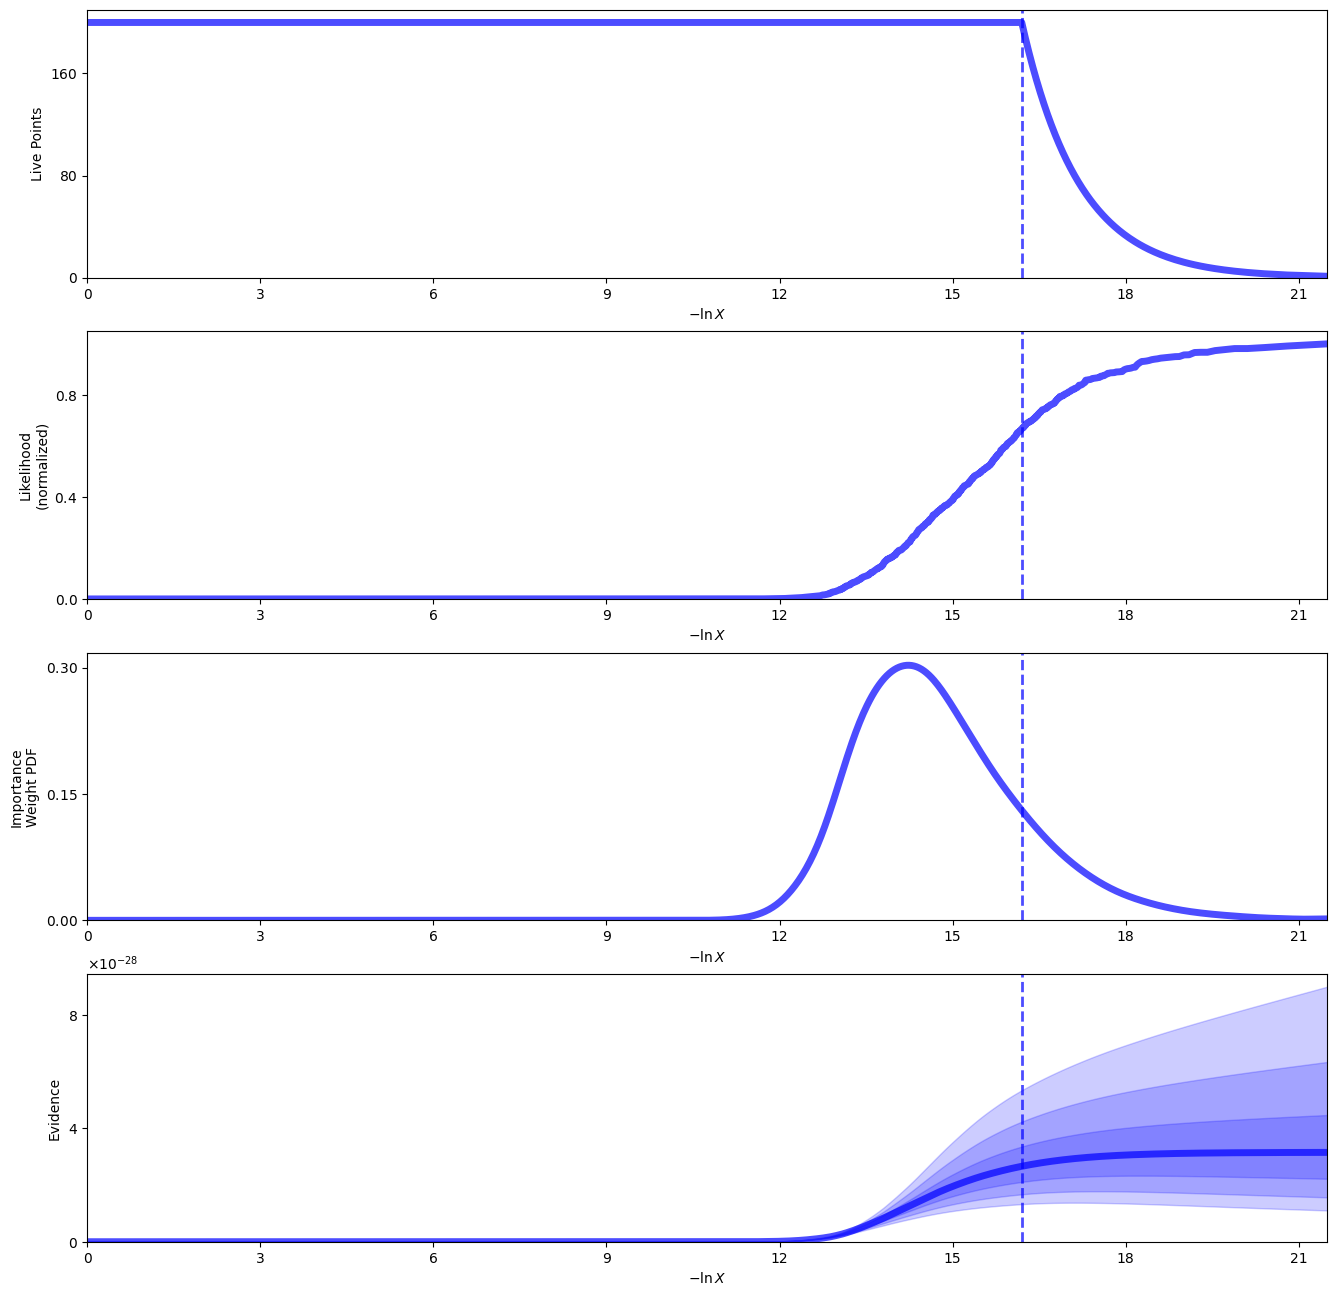

In [8]:
from dynesty import plotting as dyplot
unplot_fig, runplot_axes = dyplot.runplot(burst_sresults)

Traceplots

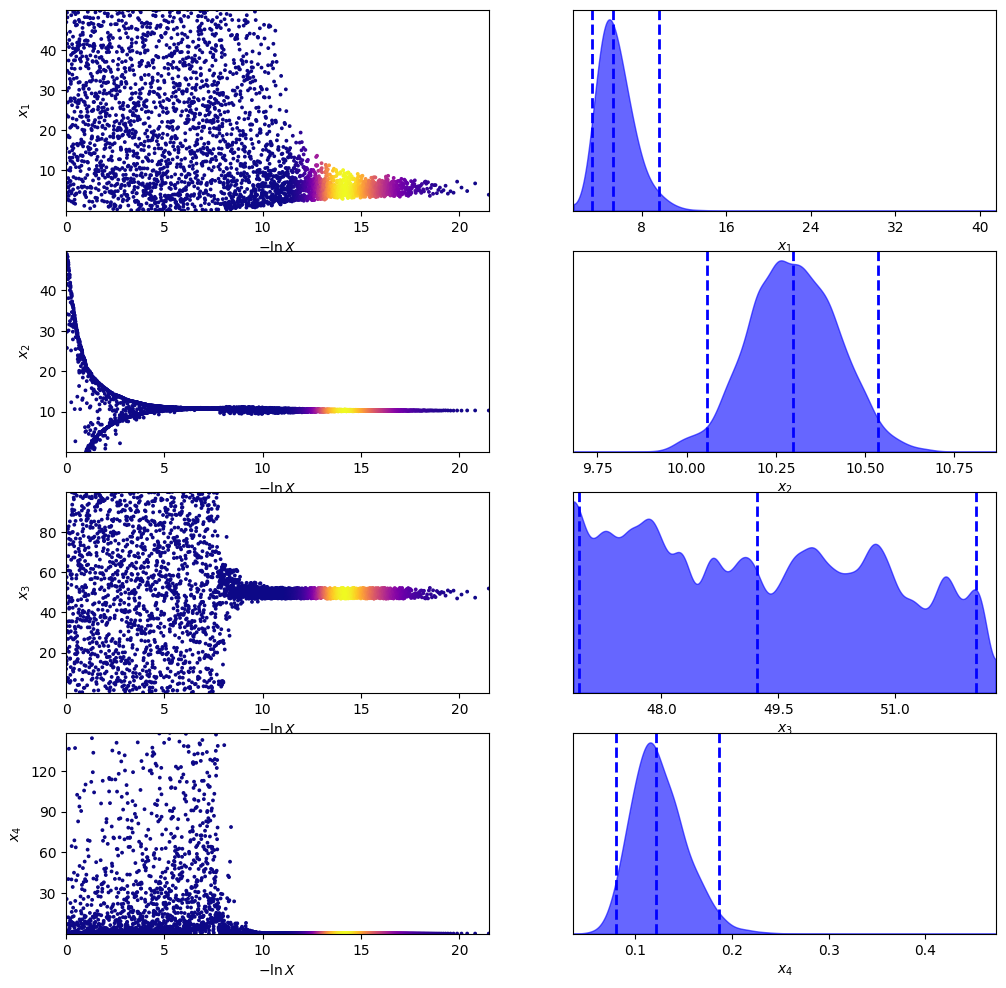

In [9]:
traceplot_fig, traceplot_axes = dyplot.traceplot(burst_sresults)

### Corner plots

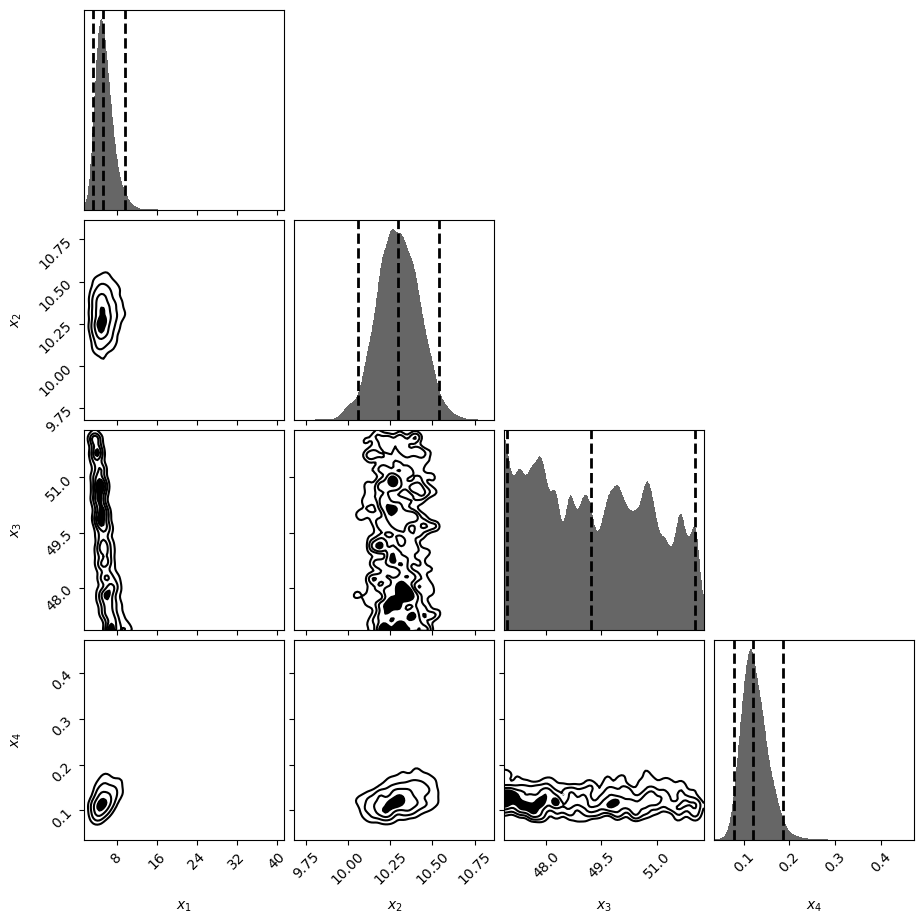

In [10]:
corner_fig, corner_axes = dyplot.cornerplot(burst_sresults)

Extract sampling results

In [11]:
from dynesty import utils as dyfunc

burst_samples = burst_sresults.samples  # samples
burst_weights = np.exp(burst_sresults.logwt - burst_sresults.logz[-1])  # normalized weights

Bayesian evidence for burst model

In [12]:
burst_log_evidence = burst_sresults.logz[-1]           #log-evidence
burst_log_evidence_error = burst_sresults.logzerr[-1]  #log-evidence error

#compute the evidence
burst_evidence = np.exp(burst_log_evidence)
print("Bayesian evidence for Burst:", burst_evidence)

#propagate the error 
burst_evidence_error = burst_evidence * burst_log_evidence_error
print("Bayesian evidence error for Burst:", burst_evidence_error)

Bayesian evidence for Burst: 3.1509321344817476e-28
Bayesian evidence error for Burst: 1.1021190545005298e-28


Median and quantiles

In [13]:
# Compute 68% quantiles
quantiles = np.array([dyfunc.quantile(samps, [0.05,0.50,0.95], weights=burst_weights)
             for samps in burst_samples.T])

labels = ["A","b","t0","alpha"]
for i,l in enumerate(labels):
    print(l+"   "+str(quantiles[i,0])+" +"+str(quantiles[i,1])+" -"+str(quantiles[i,2]))

A   3.50718923074321 +5.307606066102448 -8.683958906561868
b   10.107934586374117 +10.297406397312933 -10.497970032286256
t0   47.0568818604378 +49.22049439564571 -51.85929989654875
alpha   0.08588877534903074 +0.12120722068687645 -0.174743702203002


In [14]:
# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(burst_samples, burst_weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Mean and covariance of parameters are: [ 5.61984595 10.29880239 49.30728396  0.12493401]
[[ 2.69463428e+00  1.44183706e-02 -1.74801970e+00  2.59037162e-02]
 [ 1.44183706e-02  1.51767368e-02 -8.79971751e-03  1.35778695e-03]
 [-1.74801970e+00 -8.79971751e-03  2.37359523e+00 -1.73014265e-03]
 [ 2.59037162e-02  1.35778695e-03 -1.73014265e-03  7.71672262e-04]]


# Gauss

In [15]:
def gauss_model(x, theta):
    A, b, t0, sigma = theta
    result = b + A * np.exp(-(x - t0)**2/(2*sigma**2))
    return result

I first try to estimate reasonable parameters visually

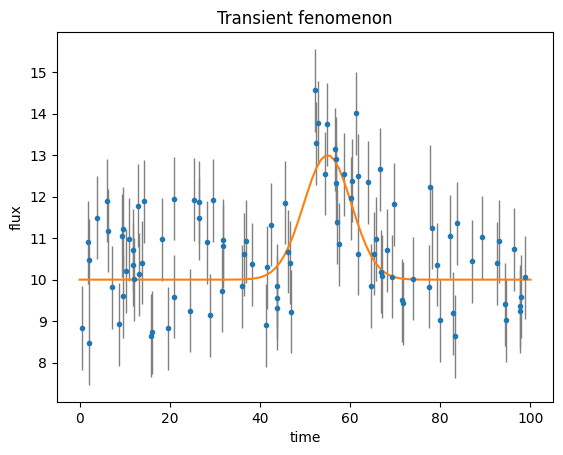

In [16]:
tgrid=np.linspace(0,100,100)
A_0=3
b_0=10
t0_0=55
sigma_0=5.3


theta_0 = np.array([A_0,b_0,t0_0,sigma_0])
ygrid = gauss_model(tgrid,theta_0)

plt.errorbar(t,y,yerr=yerr, fmt='.', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')
plt.plot(tgrid,ygrid);

In [17]:
Amin, Amax = 0, 50
bmin, bmax = 0, 50
t0min, t0max = 0, 100
sigmamin, sigmamax = np.exp(-2), np.exp(2)

def gauss_prior_transform(u):
    x = np.zeros(len(u))

    x[0] = scipy.stats.uniform(loc=Amin, scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin, scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min, scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3], sigmamin, sigmamax)

    # Tried but too slow
    #u = np.random.rand(4)  
    #x[0] = u[0] * (Amax - Amin) + Amin 
    #x[1] = u[1] * (bmax - bmin) + bmin
    #x[2] = u[2] * (t0max - t0min) + t0min
    #x[3] = np.exp(u[3] * (np.log(alphamax) - np.log(alphamin)) + np.log(alphamin)) 

    return x

In [18]:
ndim = 4             # number of parameters in the model

sampler = dynesty.NestedSampler(LogLikelihood, gauss_prior_transform, ndim, logl_args=[data, 'gauss'], nlive=200)

sampler.run_nested()
gauss_sresults = sampler.results

1643it [00:25,  7.25it/s, bound: 67 | nc: 220 | ncall: 27443 | eff(%):  5.987 | loglstar:   -inf < -86.634 <    inf | logz: -94.687 +/-  0.188 | dlogz: 29.523 >  0.209]   /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a ve

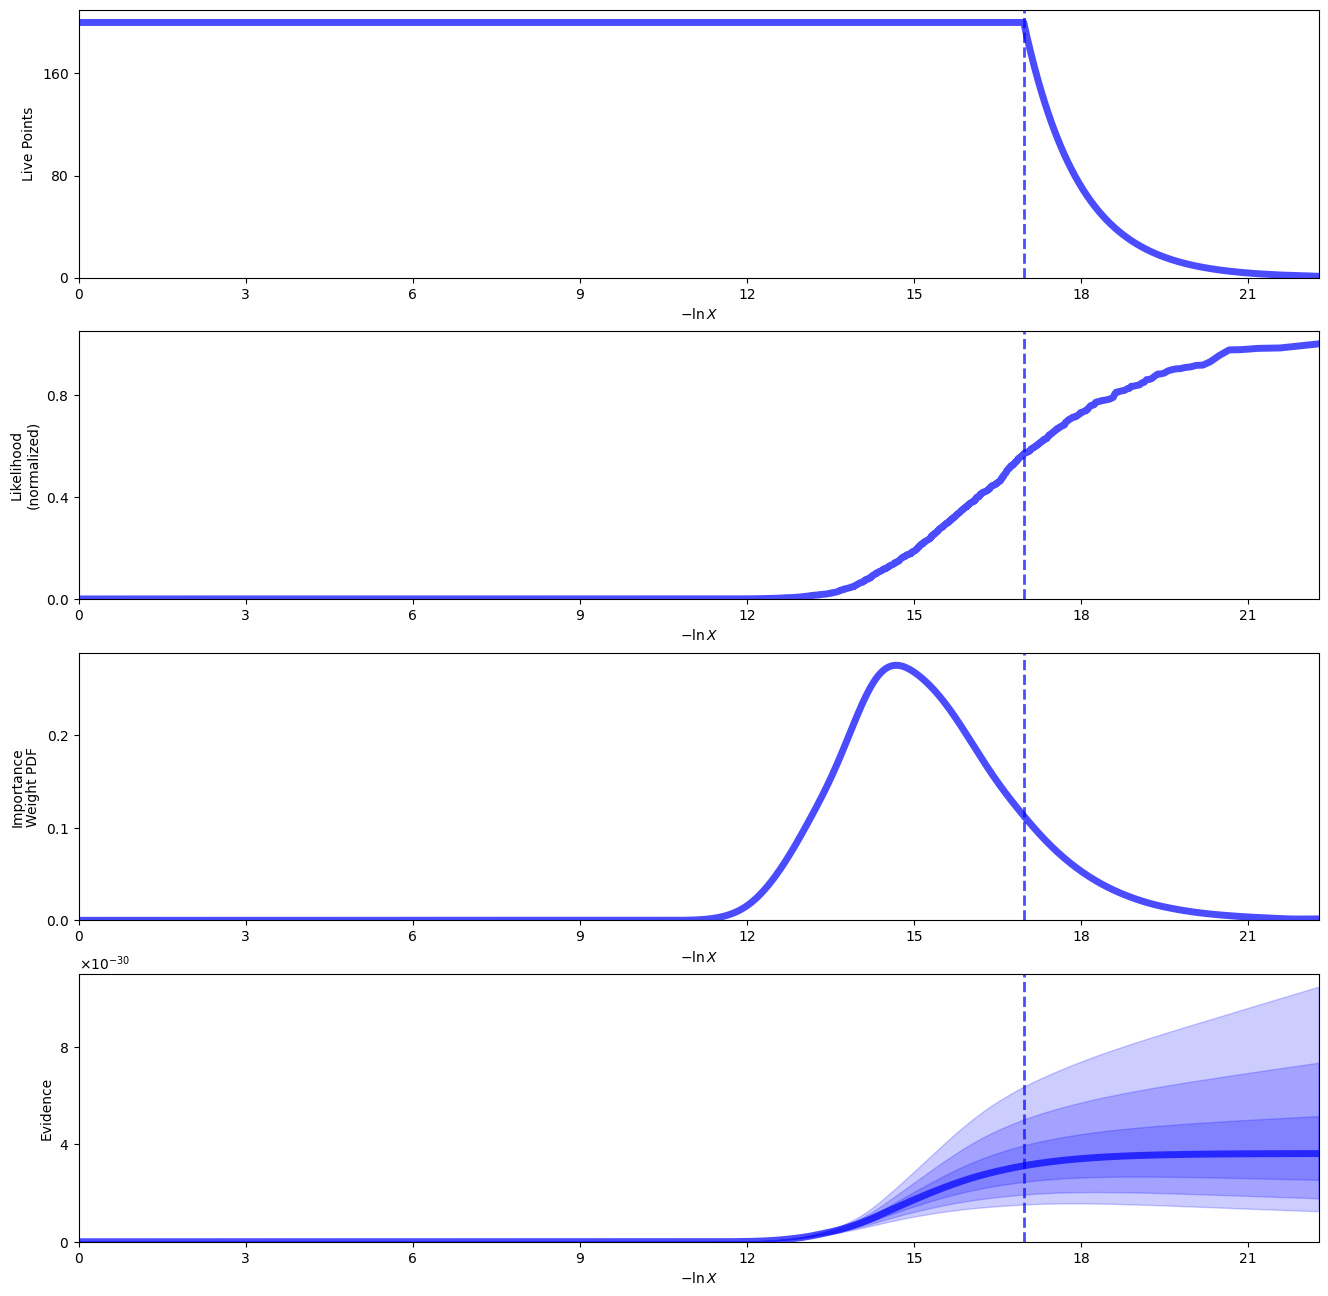

In [19]:
unplot_fig, runplot_axes = dyplot.runplot(gauss_sresults)

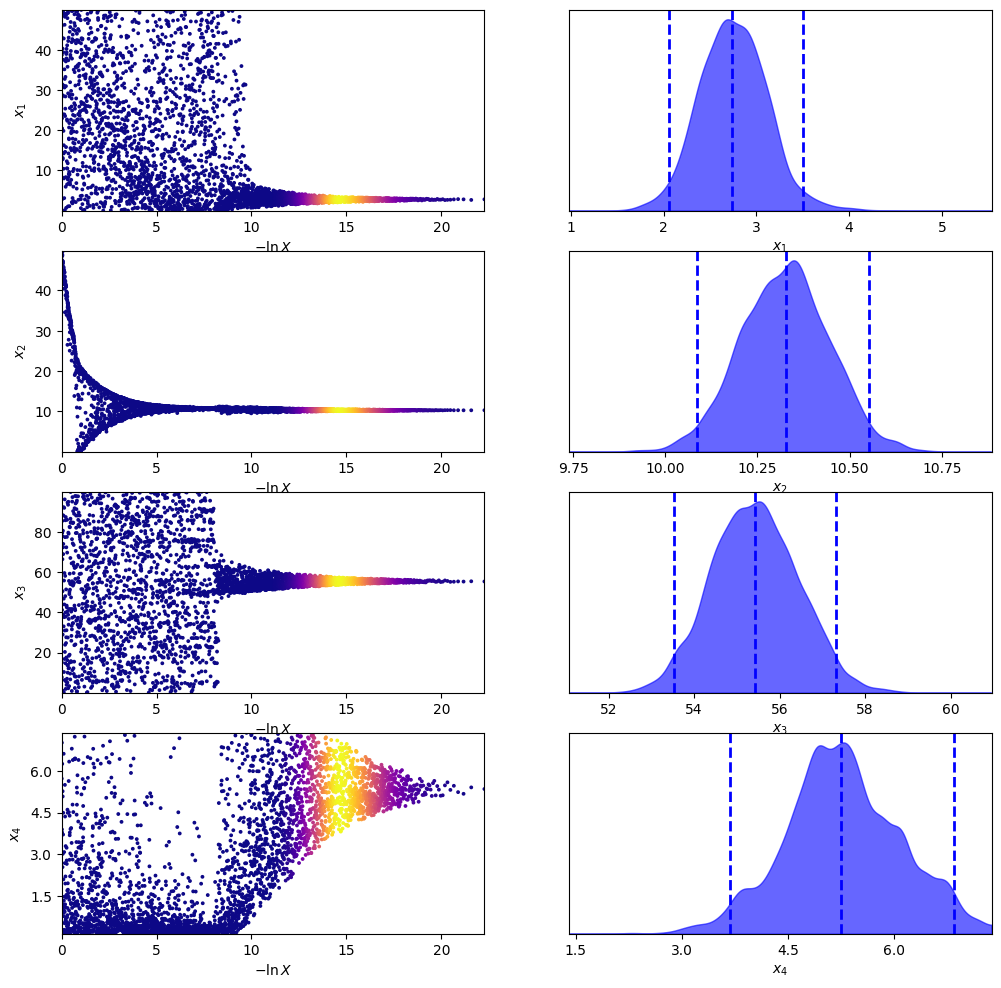

In [20]:
traceplot_fig, traceplot_axes = dyplot.traceplot(gauss_sresults)

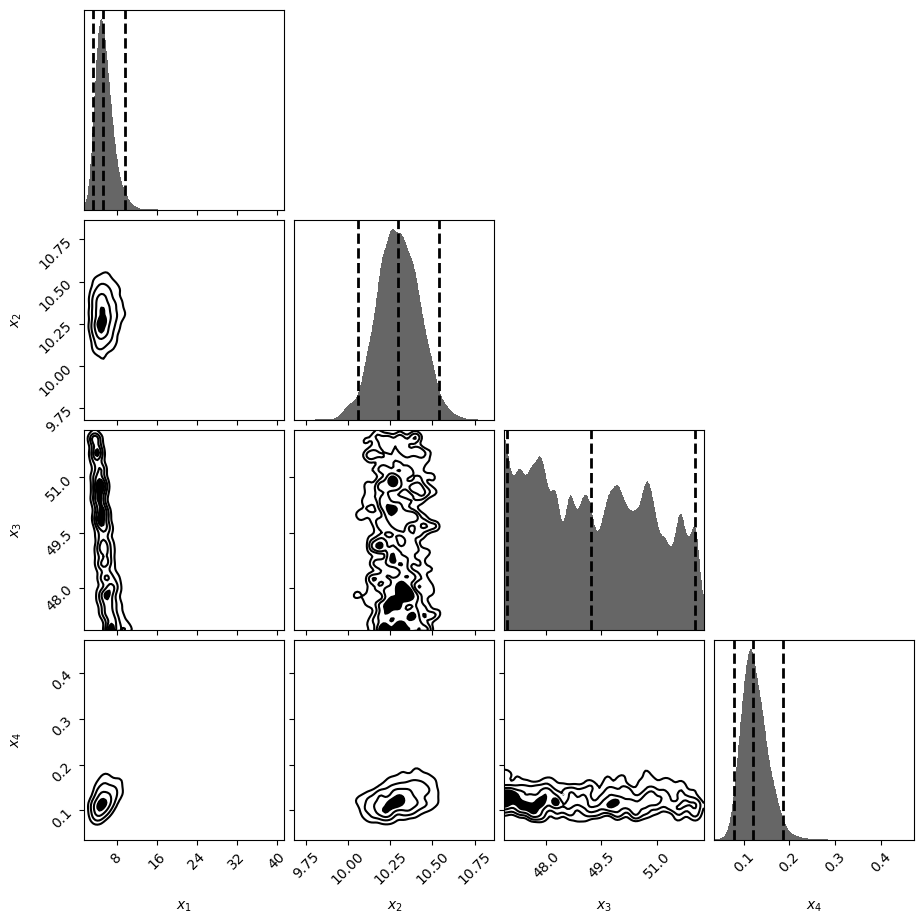

In [21]:
corner_fig, corner_axes = dyplot.cornerplot(burst_sresults)

In [22]:
gauss_log_evidence = gauss_sresults.logz[-1]           #log-evidence
gauss_log_evidence_error = gauss_sresults.logzerr[-1]  #log-evidence error

#compute the evidence
gauss_evidence = np.exp(gauss_log_evidence)
print("Bayesian evidence for Gauss:", gauss_evidence)

#propagate the error 
gauss_evidence_error = gauss_evidence * gauss_log_evidence_error
print("Bayesian evidence error for Gauss:", gauss_evidence_error)

Bayesian evidence for Gauss: 3.6170438223899045e-30
Bayesian evidence error for Gauss: 1.2808551106430594e-30


In [23]:
from dynesty import utils as dyfunc

gauss_samples = gauss_sresults.samples  # samples
gauss_weights = np.exp(gauss_sresults.logwt - gauss_sresults.logz[-1])  # normalized weights

gauss_quantiles = np.array([dyfunc.quantile(samps, [0.05,0.50,0.95], weights=gauss_weights)
             for samps in gauss_samples.T])

labels = ["A","b","t0","alpha"]
for i,l in enumerate(labels):
    print(l+"   "+str(gauss_quantiles[i,0])+" +"+str(gauss_quantiles[i,1])+" -"+str(gauss_quantiles[i,2]))

A   2.1905620836895694 +2.7335141223086596 -3.3353672603044457
b   10.12744550030996 +10.32706149454114 -10.518024010443325
t0   53.76111809214522 +55.416794121327634 -57.08209972088594
alpha   3.8702516646754823 +5.243858799122481 -6.699692804014294


In [24]:
# Compute weighted mean and covariance.
gauss_mean, gauss_cov = dyfunc.mean_and_cov(gauss_samples, gauss_weights)
print('Mean and covariance of parameters are: ' + str(gauss_mean) + '\n' + str(gauss_cov))

Mean and covariance of parameters are: [ 2.75119011 10.32430487 55.41995686  5.26737435]
[[ 0.13057461 -0.00640888 -0.12446461 -0.12593629]
 [-0.00640888  0.01429012 -0.02482165 -0.03713057]
 [-0.12446461 -0.02482165  1.00732865  0.30536167]
 [-0.12593629 -0.03713057  0.30536167  0.65863509]]


# Compare evidences

In [25]:
bayes_factor = burst_evidence/gauss_evidence
print('Bayes factor: ' + str(bayes_factor))

bayes_factor_error = bayes_factor * np.sqrt((burst_evidence_error/burst_evidence)**2 + (gauss_evidence_error/gauss_evidence)**2)
print('Bayes factor error: ' + str(bayes_factor_error))

Bayes factor: 87.11346307106169
Bayes factor error: 43.35953766235095


In [26]:
def bayes_factor_to_jeffreys(bf):
    if bf < 1:
        return "Negative"
    elif 1 <= bf < 3:
        return "Barely worth mentioning"
    elif 3 <= bf < 10:
        return "Substantial"
    elif 10 <= bf < 30:
        return "Strong"
    elif 30 <= bf < 100:
        return "Very strong"
    elif bf >= 100:
        return "Decisive"

In [27]:
print('Jeffrey scale (for Burst:Gauss): ' + bayes_factor_to_jeffreys(bayes_factor))

Jeffrey scale (for Burst:Gauss): Very strong
